# Solutions for Lab Sheet 5 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-5-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling (uncomment if you want)
import numpy as np               # math

Let's download a wave file containing speech:

In [5]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0  5953k      0 --:--:-- --:--:-- --:--:-- 6090k


As done before several time by now, we can load it to a variable and play it back (if we like).

In [6]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


## Spectrogram (Task 1)

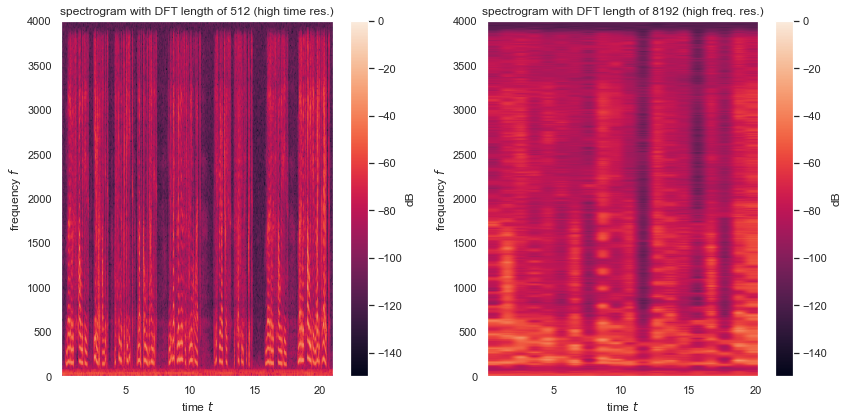

In [14]:
# visualise
fig=plt.figure(figsize=(12,6)) # create a figure of size 12 x 6 inches

LDFT=512

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high time res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)


LDFT=8192

plt.subplot(1,2,2)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high freq. res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)

plt.tight_layout()

## Filtering by Piecewise Linear Filters (Task 2)

Helper functions:

In [15]:
def plot_tolerance_scheme(wp=0.25,ws=0.3,Rp_lin=0.9,Rs_lin=0.1):
    ''' plot limits '''
    dh1x=[0,ws];  dh1y=[1,1];     
    dh2x=[0,wp];  dh2y=[Rp_lin,Rp_lin]; 
    dv2x=[wp,wp]; dv2y=[0,Rp_lin];   
    sh1x=[ws,1];  sh1y=[Rs_lin,Rs_lin]; 
    sh2x=[wp,1];  sh2y=[0,0]; 
    svx=[ws,ws];  svy=[Rs_lin,1];  
    plt.plot(dh1x,dh1y,'k--',dh2x,dh2y,'k--',dv2x,dv2y,'k--',sh1x,sh1y,'k--',
          sh2x,sh2y,'k--',svx,svy,'k--');
    plt.xlabel('Frequency $\Omega/\pi$');
    
def zplane(z, p, title='Poles and Zeros'):
    "Plots zeros and poles in the complex z-plane"
    ax = plt.gca()

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms=10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms=10)
    unit_circle = plt.Circle((0, 0), radius=1, fill=False,
                             color='black', ls='--', alpha=0.9)
    ax.add_patch(unit_circle)

    plt.title(title)
    plt.xlabel('Re{$z$}')
    plt.ylabel('Im{$z$}')
    plt.axis('equal')

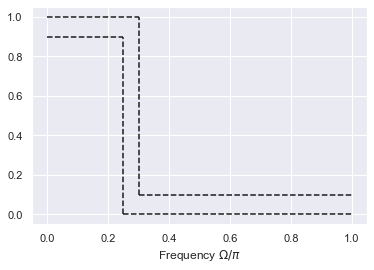

In [47]:
wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)

The slightly changes tolerance scheme which should be created for Task 2 looks like this:

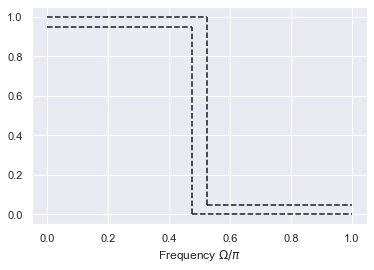

In [48]:
wp=0.475;    # passband edge frequency 
ws=0.525;     # stopband edge frequency 
Rp_lin=0.95; # allowed ripples in the pass band area
Rs_lin=0.05; # allowed ripples in the stop band area

plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)

The code below exemplarily shows two (comjugate complex) zeros at positions $z_{0,1}= -0.9$ and $z_{0,2} = 0.8$ (indicated by the blue circles) as well as a poles at positions $z_{\infty,1}=0.5 + 0.5j$ and $z_{\infty,2}=0.5 - 0.5j$ (indicated by the red crosses)  in the $z$ plane. The code above is a helper-function to plot the zeros and poles.

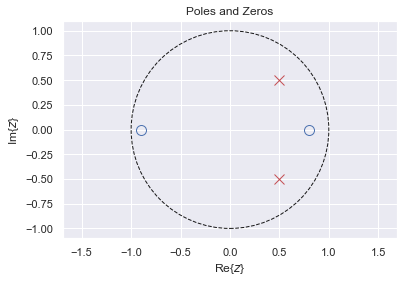

In [44]:
poles = [0.5-0.5j, 0.5+0.5j] # two (comjugate complex) poles
zeros = [-0.9, 0.8]          # two (real-valued) zeros
zplane(zeros,poles)

### Butterworth Filter Design  (Task 3)

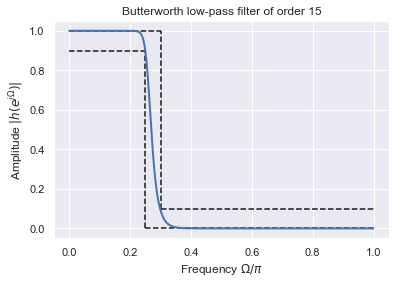

In [49]:
from scipy import signal         # filter designs

wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');

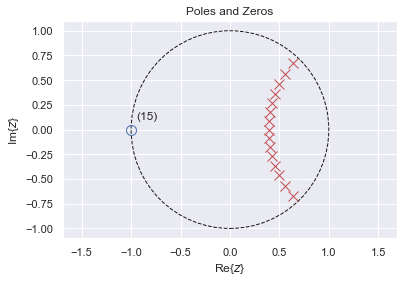

In [50]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a))
plt.text(-0.95,0.1,'('+str(N)+')');

Task 3 is solved like follows:

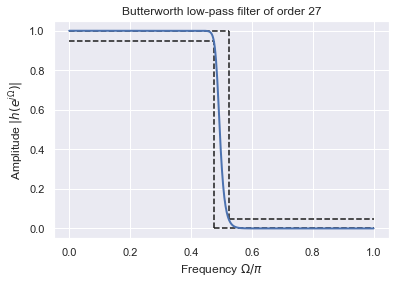

In [52]:
wp=0.475;    # passband edge frequency 
ws=0.525;     # stopband edge frequency 
Rp_lin=0.95; # allowed ripples in the pass band area
Rs_lin=0.05; # allowed ripples in the stop band area

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');

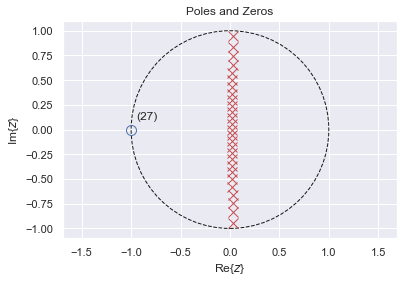

In [53]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a))
plt.text(-0.95,0.1,'('+str(N)+')');

### Chebyshev I and Chebyshev II filter design

Chebyshev filter designs make better use of the tolerance scheme by allowing for ripples in the pass band (Chebyshev I filter design) or stop band (Chebyshev II filter design), respectively. By this, the number of necessary filter coefficients $N$ can be reduced in comparison to the Butterworth filter.

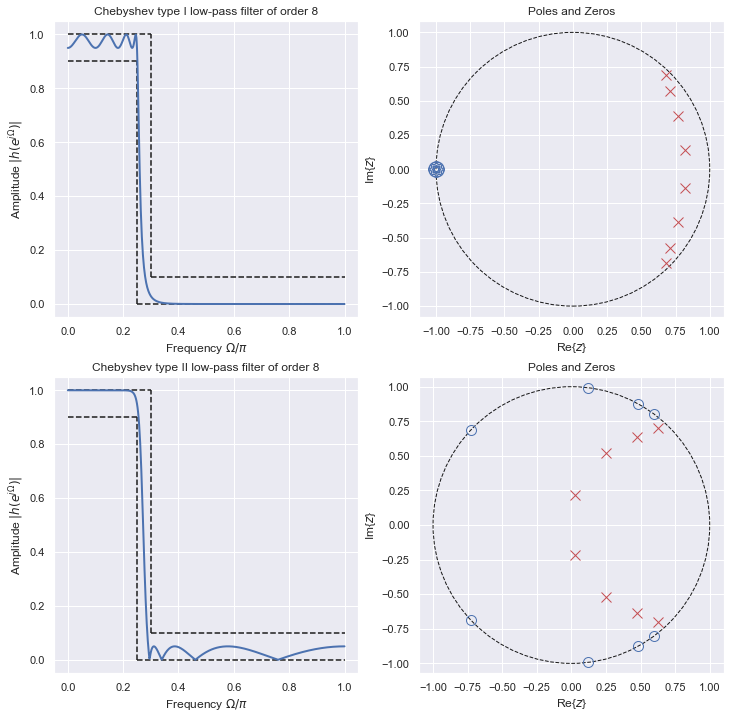

In [56]:

wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area


# get lowest filter order N to fullfill requirements above
N, Wn = signal.cheb1ord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.cheby1(N, Rp, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

plt.figure(figsize=(12, 12))

# plot frequency response
plt.subplot(2,2,1)
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Chebyshev type I low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
#plt.show()

# plot zeros and poles in the z plane
plt.subplot(2,2,2)
zplane(np.roots(b), np.roots(a))

# get lowest filter order N to fullfill requirements above
N, Wn = signal.cheb2ord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.cheby2(N, Rs, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plt.subplot(2,2,3)
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Chebyshev type II low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
#plt.show()

# plot zeros and poles in the z plane
plt.subplot(2,2,4)
zplane(np.roots(b), np.roots(a))

### Cauer Filter a.k.a. Elliptical Filter Design

The number of necessary filter coefficients $N$ can be further reduced in comparison to the Butterworth, and Chebyshev I and II filters.

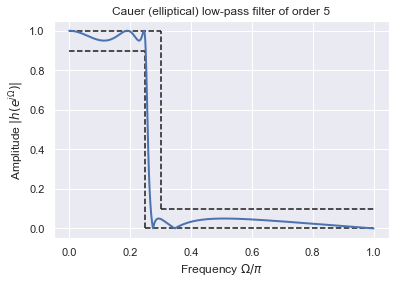

In [57]:
# get lowest filter order N to fullfill requirements above
N, Wn = signal.ellipord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.ellip(N, Rp, Rs, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Cauer (elliptical) low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
plt.show()

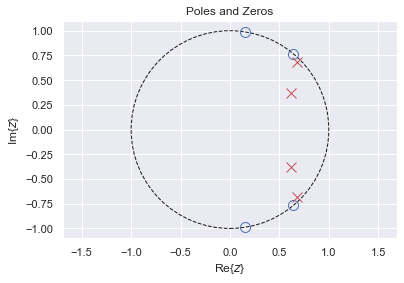

In [24]:
# plot zeros and poles in the z plane
zplane(np.roots(b), np.roots(a))

### Band pass and plotting in dB

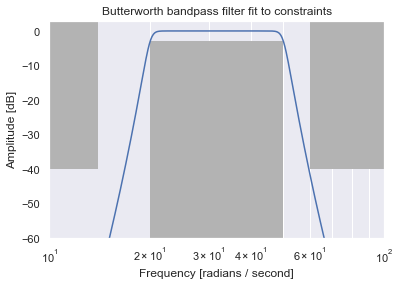

In [28]:
N, Wn = signal.buttord([20, 50], [14, 60], 3, 40, True)
b, a = signal.butter(N, Wn, 'band', True)
w, h = signal.freqs(b, a, np.logspace(1, 2, 500))
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth bandpass filter fit to constraints')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.grid(which='both', axis='both')
plt.fill([1,  14,  14,   1], [-40, -40, 99, 99], '0.7', lw=0) # stop
plt.fill([20, 20,  50,  50], [-99, -3, -3, -99], '0.7', lw=0) # pass
plt.fill([60, 60, 1e9, 1e9], [99, -40, -40, 99], '0.7', lw=0) # stop
plt.axis([10, 100, -60, 3]);